In [1]:
import os, sys
ROOT_DIR = os.path.abspath("..")
sys.path.append(ROOT_DIR)

In [2]:
import neo4j
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from random_qa.cli import init_env, open_json

plt.rcParams["font.sans-serif"] = ["Liberation Sans"]

In [3]:
init_env()

Loaded tqdm widget for notebooks

In [4]:
llm_names = ("gpt-4o", "gpt-3.5-turbo", "llama3.3-70b", "codellama-70b", "qwen2.5-coder-32b")
df_samples = pd.DataFrame(open_json(os.path.join(ROOT_DIR, "experiments", "samples_rep=5_seed=123.json.gz"), mode="r")).set_index("sample_id")

In [5]:
with neo4j.GraphDatabase.driver("bolt://localhost:7687") as driver:
    with driver.session() as session:
        # Count number of labels and relationship types using Cypher queries
        df_labels = pd.DataFrame(
            session.run("MATCH (n) UNWIND labels(n) AS label RETURN label, COUNT(*) AS count").data(),
        ).set_index("label")["count"].sort_values(ascending=False)
        df_rel_types = pd.DataFrame(
            session.run("MATCH ()-[r]->() UNWIND type(r) AS rel_type RETURN rel_type, COUNT(*) AS count").data()
        ).set_index("rel_type")["count"].sort_values(ascending=False)

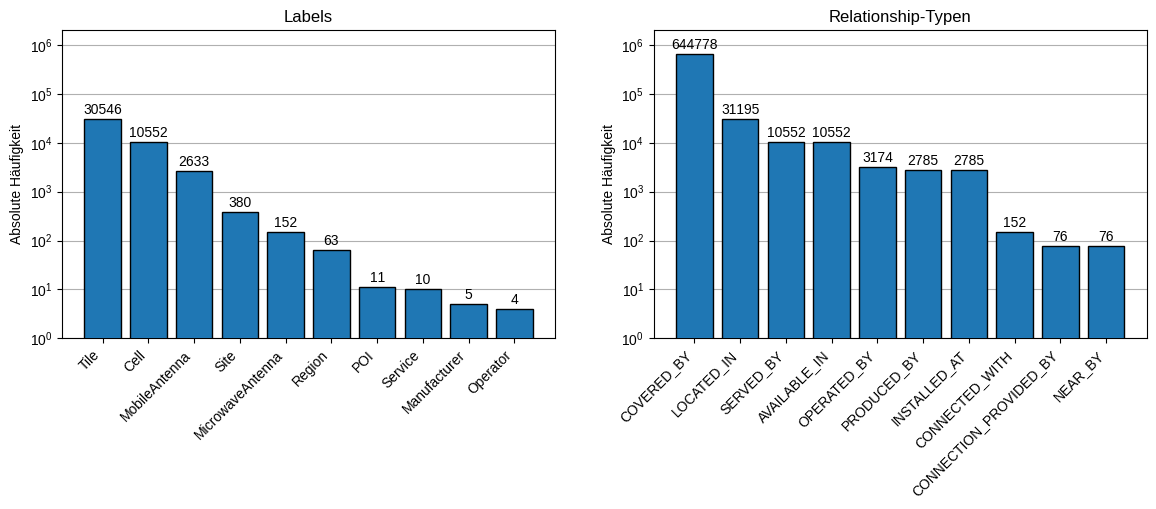

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
for i, data in enumerate((df_labels, df_rel_types)):
    bars = axs[i].bar(data.index, data, zorder=4, color="tab:blue", edgecolor="black")
    for rect in bars:
        height = rect.get_height()
        axs[i].text(rect.get_x() + rect.get_width() / 2, height*1.1, height, ha="center", va="bottom", color="black", zorder=5)
    axs[i].set_yscale("log")
    axs[i].set_yticks([], minor=True)
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=45, ha='right')
    axs[i].grid(axis="y", zorder=2)
    axs[i].set_ylim(1, 2e6)
    axs[i].set_ylabel("Absolute Häufigkeit")
    axs[i].set_title("Labels" if i == 0 else "Relationship-Typen")

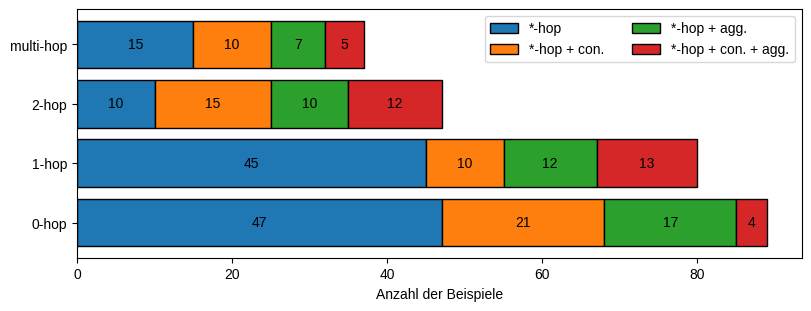

In [7]:
hops = tuple(f"{n}-hop" if n != 3 else "multi-hop" for n in range(4))

categories = [
    "*-hop", "*-hop + con.", "*-hop + agg.", "*-hop + con. + agg."
]
distribution = np.zeros((len(categories), len(hops)))
for labels in df_samples.labels:
    x, y = 0, 0
    for label in labels:
        if label.endswith("-hop"):
            x = hops.index(label) + 1
        elif label == "constraint":
            y |= 1 << 0
        elif label == "aggregation":
            y |= 1 << 1
        else:
            raise ValueError(f"Unknown label {label}")
    
    if x == 0:
        raise ValueError("Hops not specified!")
    
    distribution[y, x - 1] += 1

y_pos = np.arange(len(hops))
fig, ax = plt.subplots(1, 1, layout='constrained', figsize=(8, 3))

offset = np.zeros(shape=(4,))
for x, label in enumerate(categories):
    width = distribution[x]
    rects = ax.barh(y_pos, width, left=offset, label=label, edgecolor="black")
    ax.bar_label(rects, label_type="center")
    offset += width

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Anzahl der Beispiele")
ax.set_yticks(y_pos, hops)
ax.legend(ncols=2)

# Visualize inference time

In [8]:
def get_task_details(llm: str):
    df_results = pd.DataFrame(
        open_json(os.path.join(ROOT_DIR, "experiments", f"inference_open-book_llm={llm}.json.gz"), mode="r")
    ).set_index("sample_id")

    if llm == "gpt-4o":
        cost_model = (2.5, 10)
    elif llm == "gpt-3.5-turbo":
        cost_model = (.5, 1.5)
    elif llm == "codellama-70b":
        cost_model = (.9, .9)
    elif llm == "llama3.3-70b":
        cost_model = (.54, .6)
    elif llm == "qwen2.5-coder-32b":
        cost_model = (.41, .43)

    task_details = []
    for sample_id, row in df_results.iterrows():
        for task_name, task_data in row.tasks.items():
            if task_name == "generate_answer":
                attempt = 1
            else:
                task_name, attempt = task_name[:-2], int(task_name[-1])

            input_tokens = task_data.get("usage", {}).get("prompt_tokens", None)
            output_tokens = task_data.get("usage", {}).get("completion_tokens", None)
            if input_tokens is not None and output_tokens is not None:
                cost = (cost_model[0] * input_tokens + cost_model[1] * output_tokens) / 1e6
                total_tokens = input_tokens + output_tokens
            else:
                cost = None
                total_tokens = None
            
            task_details.append({
                "sample_id": sample_id,
                "task_name": task_name,
                "attempt": attempt,
                "success": task_data["success"],
                "duration": task_data.get("duration"),
                "cost": cost,
                "total_tokens": total_tokens,
                "system_fingerprint": task_data.get("system_fingerprint"),
                "llm": task_data.get("model"),
                "error_type": task_data.get("reason")
            })

    return pd.DataFrame(task_details)

14.876061684001163, 62.34867377200217, 26.46737524099923, 3.240473459998785, 3.885881506001129


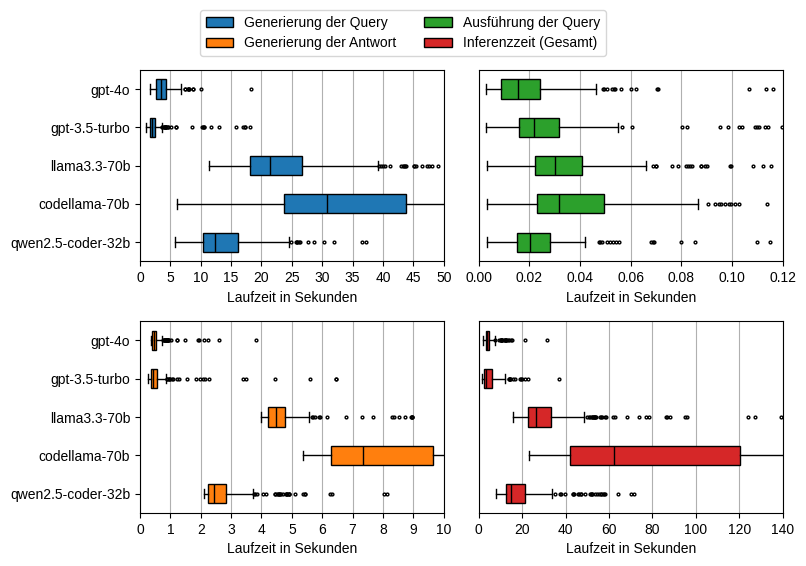

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5))
llm_names = ("gpt-4o", "gpt-3.5-turbo", "llama3.3-70b", "codellama-70b", "qwen2.5-coder-32b")

tasks = ["generate_query", "execute_query", "generate_answer"]
tasks = [*map(lambda x: [x], tasks), tasks]

colors = [
    "tab:blue", "tab:green", "tab:orange",  "tab:red"
]

for i, task_name in enumerate(tasks):
    ax = axs[np.unravel_index(i, axs.shape)]
    data = []
  
    for llm in llm_names[::-1]:
        df = get_task_details(llm)
        df = df[df.task_name.isin(task_name)]
        if i == 3:
            data.append(df.groupby("sample_id").duration.sum())
        else:
            data.append(df.duration.dropna())

    ax.set_xlabel("Laufzeit in Sekunden")
    ax.boxplot(
        data,   
        showfliers=True,
        vert=False,
        zorder=3,
        boxprops={"facecolor": colors[i]},
        medianprops={"color": "black"},
        flierprops={"marker": "o", "markersize": 2, },
        patch_artist=True,
    )
    if i % 2 == 0:
        ax.set_yticklabels(llm_names[::-1])
    else:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    if i == 0:
        ax.set_xticks(np.arange(0, 81, 5))
        ax.set_xlim([0, 50])
    elif i == 2:
        ax.set_xticks(np.arange(0, 17, 1))
        ax.set_xlim([0, 10])
    elif i == 1:
        ax.set_xticks(np.arange(0, 0.13, 0.02))
        ax.set_xlim([0, 0.12])
    elif i == 3:
        ax.set_xticks(np.arange(0, 150, 20))
        ax.set_xlim([0, 140])
        print(", ".join(map(lambda x: str(x.median()), data)))
        
    ax.grid(axis="x", zorder=1)

labels = ["Generierung der Query", "Ausführung der Query", "Generierung der Antwort", "Inferenzzeit (Gesamt)"]

fig.legend(
    handles=[
        mpatches.Patch(edgecolor="black", facecolor=colors[i], label=labels[i])
        for i in (0, 2, 1, 3)
    ],
    loc="lower center",
    ncols=2,
    bbox_to_anchor=(0.5, 1)
)
fig.tight_layout(h_pad=1.2, w_pad=1, pad=.5)

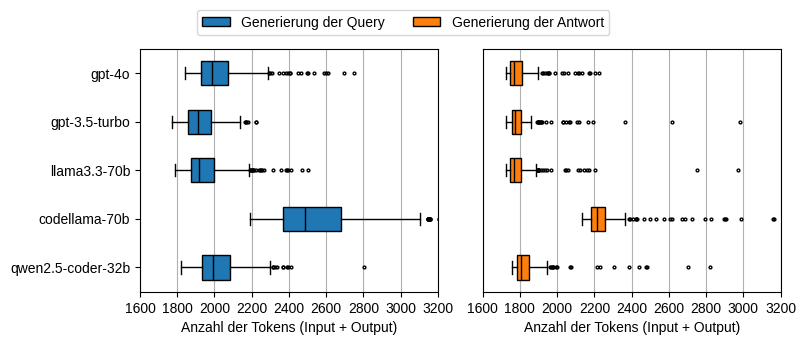

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

tasks = ["generate_query", "generate_answer"]

colors = [
    "tab:blue", "tab:orange",
]

for i, task_name in enumerate(tasks):
    ax = axs[np.unravel_index(i, axs.shape)]
    data = []
  
    for llm in llm_names[::-1]:
        df = get_task_details(llm)
        df = df[df.task_name == task_name]
        data.append(df.total_tokens)
        
    ax.set_xlabel("Anzahl der Tokens (Input + Output)")
    ax.boxplot(
        data,   
        showfliers=True,
        vert=False,
        zorder=3,
        boxprops={"facecolor": colors[i]},
        medianprops={"color": "black"},
        flierprops={"marker": "o", "markersize": 2, },
        patch_artist=True,
    )
    if i % 2 == 0:
        ax.set_yticklabels(llm_names[::-1])
    else:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    if i == 0:
        ax.set_xticks(np.arange(1600, 3400, 200))
        ax.set_xlim([1600, 3200])
    else:
        ax.set_xticks(np.arange(1600, 3400, 200))
        ax.set_xlim([1600, 3200])
        
    ax.grid(axis="x", zorder=1)

labels = ["Generierung der Query", "Generierung der Antwort"]

fig.legend(
    handles=[
        mpatches.Patch(edgecolor="black", facecolor=colors[i], label=labels[i])
        for i in range(2)
    ],
    loc="lower center",
    ncols=2,
    bbox_to_anchor=(0.5, 1)
)
fig.tight_layout(h_pad=1.2, w_pad=1, pad=.5)

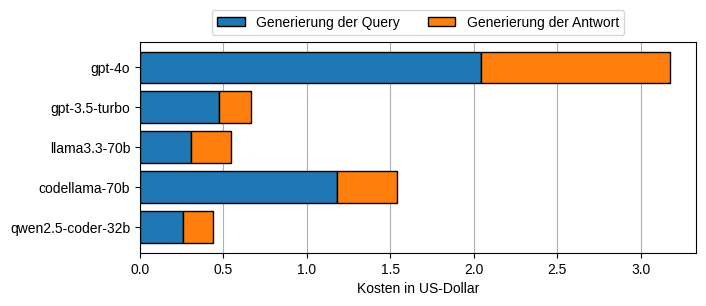

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
bottom = np.zeros(shape=len(llm_names))
for task_type in ("query", "answer"):
    height = np.zeros(shape=len(llm_names))
    for i, llm in enumerate(llm_names[::-1]):
        df = get_task_details(llm)
        height[i] = df[df.task_name == f"generate_{task_type}"].cost.sum()


    label = "Generierung der Query" if task_type == "query" else "Generierung der Antwort"
    rects = ax.barh(llm_names[::-1], width=height, left=bottom, label=label, zorder=2, edgecolor="black")
    bottom += height

    #ax.bar_label(rects, label_type="center", fmt="%.2f")
ax.set_xlabel("Kosten in US-Dollar")
ax.legend(loc="lower center", ncols=4,bbox_to_anchor=(0.5, 1))
ax.grid(axis="x", zorder=1)
fig.tight_layout(pad=.5)

In [12]:
data = []
prompt_tokens = 0
completion_tokens = 0

for llm in llm_names:
    for scenario in ("closed-book", "open-book", "oracle"):
        try:
            df = pd.DataFrame(open_json(os.path.join(ROOT_DIR, "experiments", f"metrics_{scenario}_llm={llm}.json.gz"), mode="r"))

            prompt_tokens += df.answer_correctness.apply(lambda x: x.get("prompt_tokens")).sum()
            completion_tokens += df.answer_correctness.apply(lambda x: x.get("completion_tokens")).sum()

            likert_scores = df.answer_correctness.apply(lambda x: x.get("score"))
            data.append({
                "llm": llm,
                "scenario": scenario,
                "em": df.answer_exact_match.mean(),
                "kwr": df.answer_keyword_recall.mean(),
                "r_bert": np.clip(df.answer_bert_score_recall, 0, 1).mean(),
                "p_bert": np.clip(df.answer_bert_score_precision, 0, 1).mean(),
                "f_bert": np.clip(df.answer_bert_score_f1, 0, 1).mean(),
                "cg_top_2": (likert_scores >= 4).mean(),
                "cg_mean": likert_scores.mean(),
            })
        except FileNotFoundError:
            pass
pd.DataFrame(data)

,llm,scenario,em,kwr,r_bert,p_bert,f_bert,cg_top_2,cg_mean
0,gpt-4o,closed-book,0.114625,0.277339,0.246281,0.273151,0.251274,0.241107,2.233202
1,gpt-4o,open-book,0.549407,0.814449,0.798436,0.795157,0.793114,0.901186,4.573123
2,gpt-4o,oracle,0.573123,0.865832,0.860017,0.839765,0.847573,0.980237,4.869565
3,gpt-3.5-turbo,closed-book,0.043478,0.202075,0.168689,0.214309,0.180744,0.193676,1.968379
4,gpt-3.5-turbo,open-book,0.276680,0.559947,0.494290,0.537990,0.509051,0.695652,3.727273
5,gpt-3.5-turbo,oracle,0.442688,0.770971,0.767717,0.747846,0.753746,0.988142,4.786561
6,llama3.3-70b,closed-book,0.118577,0.268445,0.268677,0.282805,0.263252,0.225296,2.169960
7,llama3.3-70b,open-book,0.442688,0.727822,0.766661,0.720939,0.740372,0.877470,4.387352
8,llama3.3-70b,oracle,0.454545,0.773441,0.808564,0.759195,0.781198,0.956522,4.667984
9,codellama-70b,closed-book,0.003953,0.185534,0.057745,0.143051,0.081707,0.154150,1.810277


In [13]:
data = []
for llm in llm_names:
    df_metrics = pd.DataFrame(open_json(os.path.join(ROOT_DIR, "experiments", f"metrics_open-book_llm={llm}.json.gz"), mode="r"))
    df_tasks = get_task_details(llm)
    tmp = np.zeros(shape=4)
    for sample_id, group_df in df_tasks.groupby("sample_id"):
        for attempt in range(1, 5):
            query_tasks = group_df[group_df.task_name.str.endswith("query") & (group_df.attempt == attempt)]
            if attempt == 4:
                tmp[3] += 1
            elif query_tasks.success.all():
                tmp[attempt - 1] += 1
                break
        
    total = tmp.sum()
    assert total == len(df_metrics)
    data.append({
        "llm": llm,
        "pass@1": f"{tmp[0]:.0f}",
        "pass@2": f"{tmp[:2].sum():.0f} (+{tmp[1]:.0f})",
        "pass@3": f"{tmp[:3].sum():.0f} (+{tmp[2]:.0f})",
        "fail": int(tmp[3]),
        "recall": df_metrics.query_recall.mean(),
        "precision": df_metrics.query_precision.mean(),
        "f1": df_metrics.query_f1.mean(),
    })
pd.DataFrame(data)

,llm,pass@1,pass@2,pass@3,fail,recall,precision,f1
0,gpt-4o,235,247 (+12),247 (+0),6,0.903162,0.747219,0.790427
1,gpt-3.5-turbo,155,194 (+39),208 (+14),45,0.702240,0.535859,0.578121
2,llama3.3-70b,230,244 (+14),245 (+1),8,0.869565,0.746292,0.780618
3,codellama-70b,111,147 (+36),176 (+29),77,0.534914,0.452083,0.470715
4,qwen2.5-coder-32b,215,234 (+19),237 (+3),16,0.839921,0.743583,0.766459


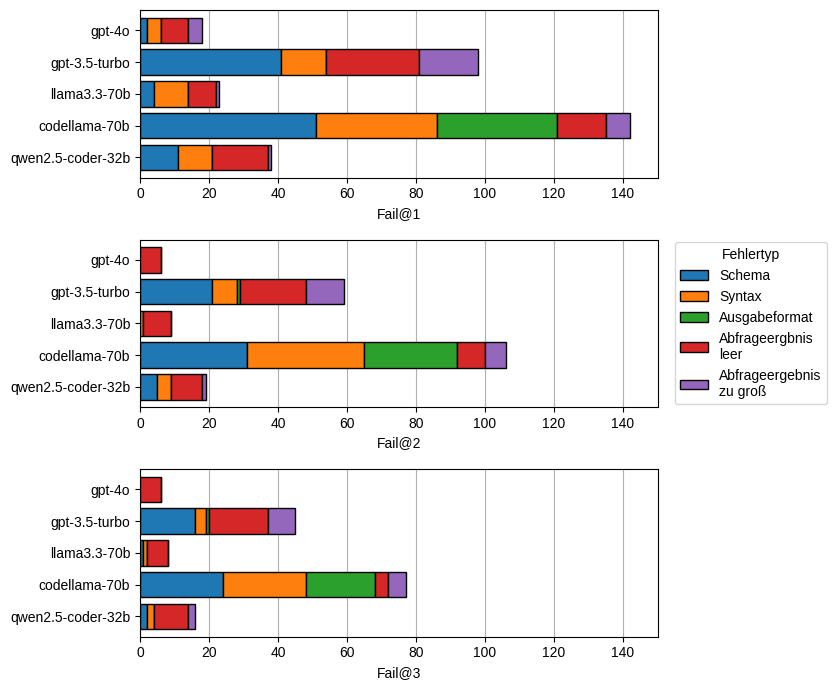

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(8.5, 7))

error_types = {
    "Schema": ["schema_error"],
    "Syntax": ["syntax_error"],
    "Ausgabeformat": ["format_error"],
    "Abfrageergbnis\nleer": ["result_empty"],
    "Abfrageergebnis\nzu groß": ["result_too_big"],
}

total_count = np.zeros(shape=len(error_types))
for attempt in range(3):
    ax = axs[np.unravel_index(attempt, axs.shape)]
    data = np.zeros(shape=(len(llm_names), len(error_types)))

    for x, error_type in enumerate(error_types):
        for y, llm in enumerate(llm_names[::-1]):
            df_tasks = get_task_details(llm)
            for sample_id, group_df in df_tasks.groupby("sample_id"):
                query_tasks = group_df[group_df.task_name.str.endswith("query") & (group_df.attempt == attempt + 1)]
                if query_tasks.success.all():
                    continue
                if (~query_tasks.success & query_tasks.error_type.isin(error_types[error_type])).any():
                    data[y, x] += 1
    
    
        ax.barh(llm_names[::-1], width=data[:, x], label=error_type, left=data[:, :x].sum(axis=1), zorder=2, edgecolor="black")

    if attempt == 1:
        ax.legend(title="Fehlertyp", loc="center left", bbox_to_anchor=(1.02, 0.5))
    
    total_count += data.sum(axis=0)

    ax.set_xlabel(f"Fail@{attempt+1}")
    ax.set_xlim([0, 150])
    ax.grid(axis="x", zorder=1)

fig.tight_layout(h_pad=1.2)

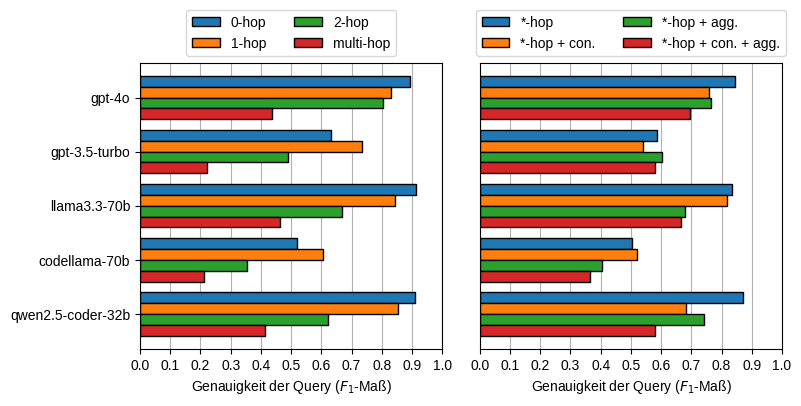

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
bar_gap = .2
bar_height = (1 - bar_gap) / 4
for j, hops in enumerate(["0-hop", "1-hop", "2-hop", "multi-hop"]):   
    data = []
    for llm in llm_names[::-1]:
        df_metrics = pd.DataFrame(open_json(os.path.join(ROOT_DIR, "experiments", f"metrics_open-book_llm={llm}.json.gz"), mode="r")).set_index("sample_id")
        df_metrics = df_metrics.join(df_samples.labels)
        data.append(df_metrics[df_metrics.labels.apply(lambda x: hops in x)].query_f1.mean())
    
    axs[0].barh(np.arange(5) + (1.5 - j) * bar_height, width=data, label=hops, height=bar_height, zorder=2, edgecolor="black")

for j in range(4):
    label = "*-hop" + ("", " + con.", " + agg.", " + con. + agg.")[j]
    data = []
    for llm in llm_names[::-1]:
        df_metrics = pd.DataFrame(open_json(os.path.join(ROOT_DIR, "experiments", f"metrics_open-book_llm={llm}.json.gz"), mode="r")).set_index("sample_id")
        df_metrics = df_metrics.join(df_samples.labels)
        data.append(df_metrics[df_metrics.labels.apply(lambda x: sum(2**n for n, t in enumerate(("constraint", "aggregation")) if t in x) == j)].query_f1.mean())
    axs[1].barh(np.arange(5) + (1.5 - j) * bar_height, width=data, label=label, height=bar_height, zorder=2, edgecolor="black")

for i in range(2):
    if i == 0:
        axs[i].set_yticks(np.arange(5))
        axs[i].set_yticklabels(llm_names[::-1])
    else:
        axs[i].tick_params(axis='y', which='both', left=False, labelleft=False)
    axs[i].set_xlim([0, 1])
    axs[i].set_xticks(np.linspace(0, 1, 11))
    axs[i].set_xlabel("Genauigkeit der Query ($F_1$-Maß)")
    axs[i].legend(loc="lower center", ncols=2, bbox_to_anchor=(0.5, 1))
    axs[i].grid(axis="x", zorder=1)
fig.tight_layout(w_pad=1, pad=.5)